This notebook demonstrates how connected seeds can be selected for sequence design, or another round of extension. Note that you will need to score the connected seeds (as in 02_scoreSeeds) prior to this step

In [ ]:
import glob
import json
import pickle
import os
import warnings
import shutil
import sys
import re
import pathlib
import subprocess

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from logomaker import *

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import PDBIO
from Bio.PDB.Polypeptide import one_to_three 
from Bio.PDB import Superimposer,Structure,Model

from rele_binder_design.utils import loadAndModifyPDBs,getPDBsFromMultiEntryFile,loadAlphaFoldResults,getRMSD,hamming_distance,selectTopNDistinctSequences
from rele_binder_design.pdbutils import multiPDBLoader,multiPDBWriter

In [21]:
path = '/data1/groups/keatinglab/swans/TIsigner/TIsigner_cmd/test/results/test_20230710-031007.csv'
df = pd.read_csv(path)
df.head()

,Type,Sequence,Opening Energy,Mismatches
0,Input,ATGCAGACCCTGCTGTCTGACGAAGACGCGGAACTGGTTGAAATCG...,17.17,NaN
1,Selected,ATGCA<mark>A</mark>ACCCT<mark>A</mark>CT<mark>...,7.74,6.0
2,Optimised,ATGCA<mark>A</mark>ACCCT<mark>A</mark>CT<mark>...,7.74,6.0
3,Optimised,ATGCA<mark>A</mark>AC<mark>A</mark>CT<mark>C</...,7.92,6.0
4,Optimised,ATGCA<mark>A</mark>ACCCT<mark>A</mark>CT<mark>...,8.04,6.0


In [27]:
re.sub('<[^<]+?>', '', df.loc[1,'Sequence'])

'ATGCAAACCCTACTATCAGATGAAGACGCCGAACTGGTTGAAATCGTTAAAGAACGTCTGGCGAAATACAAAGAATACCCGATCCTGGGTCCGGAAGGTGCGAAAAAACTGTAG'

In [26]:
website = 'ATGCAAACATTATTAAGTGACGAAGACGCAGAACTGGTTGAAATCGTTAAAGAACGTCTGGCGAAATACAAAGAATACCCGATCCTGGGTCCGGAAGGTGCGAAAAAACTGTAG'
website == re.sub('<[^<]+?>', '', df.loc[1,'Sequence'])

False

In [24]:
len(website)

114

In [25]:
len(df.loc[1,'Sequence'].replace('</mark>','').replace('<mark>',''))

114

# Create smaller multiPDB containing seeds, for convenience

In [33]:
oldmultipdbpath = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4/1_generateSeeds_100k_noSeqConst_new/4FXE-ARG81-relax-noHyd_E_B.seeds.pdb'
newmultipdbpath = '4FXE-ARG81-relax-noHyd_E_B_seeds_filteredbyscore.pdb'
selectedseedspath = '/data1/groups/keatinglab/swans/binderDesign_relE/analysis/round4/230317_top20kseeds_clusteredto10k_list.txt'
with open(selectedseedspath) as file:
    selectedseedsset = set([x.rstrip() for x in file])

with multiPDBLoader(oldmultipdbpath) as reader:
    reader.copyToNewMultiPDB(selectedseedsset,newmultipdbpath)

Scanning multi-PDB file...
Scanned the file in 23.708 s and found 1393105 structures


In [2]:
oldmultipdbpath = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4/1_generateSeeds_100k_noSeqConst_new/4FXE-ARG81-relax-noHyd_E_B.seeds.pdb'
newmultipdbpath = '4FXE-ARG81-relax-noHyd_E_B_seeds_filteredbyscore2.pdb'
selectedseedspath = '/data1/groups/keatinglab/swans/binderDesign_relE/analysis/round4/230317_top20kseeds_clusteredto10k_list.txt'
with open(selectedseedspath) as file:
    selectedseedsset = set([x.rstrip() for x in file])

with multiPDBLoader(oldmultipdbpath) as reader:
    reader.copyToNewMultiPDB(selectedseedsset,newmultipdbpath)

Scanning multi-PDB file...
Scanned the file in 16.481 s and found 1393105 structures


# Score native (for comparison to designs)

In [2]:
path = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4/2_nativePeptide_mpnodeupdate_etabnorm_proteomebg/wholepeptide/structureBinderScores.csv'
native_df = pd.read_csv(path)
native_df['seqstruct_score_per_res'] = native_df['seqstruct_score'] / 32
native_df['struct_score_per_res'] = native_df['struct_score'] / 32
native_df

,name,score_mode,N_target_res,N_peptide_res,seqstruct_score,struct_score,seqstruct_score_per_res,struct_score_per_res
0,4FXE-ARG81-relax-noHyd_E_B,interface_only,82,32,-69.532784,-30.088892,-2.172899,-0.940278


# Score extensions (full set)

## Score 1-seed extensions

In [3]:
path = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4_repeatNativeExtensions/5_scoreExtensions1seed_8resConnectors/structureBinderScores.csv'
df = pd.read_csv(path)
df['struct_score_per_res'] = df['struct_score'] / df['N_peptide_res']
df['seqstruct_score_per_res'] = df['seqstruct_score'] / df['N_peptide_res']
print(len(df))
path = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4_repeatNativeExtensions/5_scoreExtensions1seed_8resConnectors/pepSeqs.csv'
seq_df = pd.read_csv(path)
df = df.merge(seq_df,on='name')
print(len(df))
df = df.drop_duplicates(['consensus_seq'])
df['name'] = df['name'].apply(lambda x: x[len('4FXE-ARG81-relax-noHyd_E__'):])
df = df.reset_index(drop=True)
df

28680
28680


,name,score_mode,N_target_res,N_peptide_res,seqstruct_score,struct_score,struct_score_per_res,seqstruct_score_per_res,nat_seq,consensus_seq,seq_id
0,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,32,-57.072914,-28.175640,-0.880489,-1.783529,QTLLSDEDAELVEIVKERLEKIDMVILAGGIC,DEEEEEEDAELREEVKEELKETDEWITIGGLE,43.750000
1,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,32,-55.342255,-28.362110,-0.886316,-1.729445,QTLLSDEDAELVEIVKERLIDADGFVEIGGIC,DEEEEEEDAELREEVAEELEEMKGGTEVGGSE,40.625000
2,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,32,-52.997742,-24.589619,-0.768426,-1.656179,QTLLSDEDAELVEIVKERLKGFLYAINAGGIC,DEEEEEEDAELRAEVKEELENFKGSHELGGLE,37.500000
3,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,32,-55.384926,-25.569084,-0.799034,-1.730779,QTLLSDEDAELVEIVKERLDHRYRMTTSGGIC,DEEEEEEDAELREEVNEVLKEETTLIELGGLK,34.375000
4,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,32,-55.344749,-20.710789,-0.647212,-1.729523,QTLLSDEDAELVEIVKERLDAYVGVRQDGGIC,DEEEEEEDAELREEVKEEIGEEKGYTEIGGKE,37.500000
...,...,...,...,...,...,...,...,...,...,...,...
28485,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,31,-54.132072,-17.252529,-0.556533,-1.746196,QTLLSDEDAELVEIVKERLPPAGPLPILNLL,DEEEEEEDAELREEVKEALPPKTPPTSALEL,45.161290
28486,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,31,-54.588715,-27.652760,-0.892025,-1.760926,QTLLSDEDAELVEIVKERKYEQQNFHLLNLL,DEEEEEEDAQLREEVKGNGNEERKTVEAEEL,29.032258
28487,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,31,-58.777306,-32.218658,-1.039312,-1.896042,QTLLSDEDAELVEIVKERDAQNYVKKPLNLL,DEEEEEEDAELRAEVKAEIGEKEKMVEAEEL,25.806452
28488,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,33,-58.425983,-31.249870,-0.946966,-1.770484,QTLLSDEDAELVEIVKERQSGTNASVFWQLNLL,DEEEEEEDAQLIEEVAGEKALEEKQKYVQIEEL,24.242424


<Axes: xlabel='N_peptide_res', ylabel='Count'>

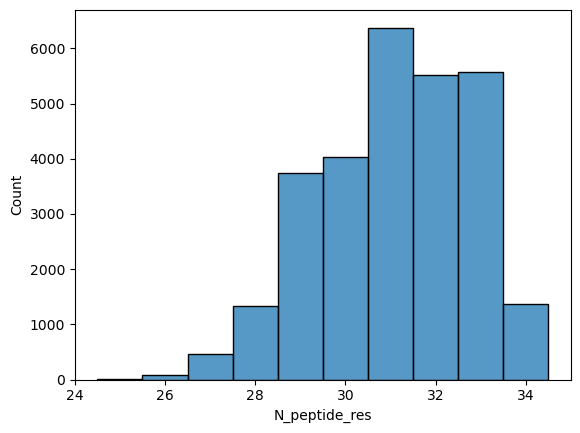

In [4]:
sns.histplot(data=df,x='N_peptide_res',discrete=True)

In [5]:
# name_mapping = dict(zip(filt_df['name'],filt_df['index'].astype(str)))
# seeds_multipdb = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4_3seeds/4_bridgeSeeds_toprelEdenovo2seeds_cluster0.95_top15/cterm_nterm_fused.pdb'
# p = PDBParser(PERMISSIVE=0)
# # target_structure = p.get_structure('','/data1/groups/keatinglab/swans/binderDesign_relE/files/4FXE-ARG81-relax-noHyd_E_.pdb')
# loadAndModifyPDBs(filt_df.head(100),seeds_multipdb,[],'4FXE_3seeds_structscoreperres-.5_seqstructtop100',
#                   '0','name','consensus_seq','seqstruct_score',False, name_mapping)

In [22]:
score_filt_df = df[df['struct_score_per_res']<df['struct_score_per_res'].median()].sort_values(by='seqstruct_score_per_res').head(5000)
score_filt_df.head()

,name,score_mode,N_target_res,N_peptide_res,seqstruct_score,struct_score,struct_score_per_res,seqstruct_score_per_res,nat_seq,consensus_seq,seq_id
23511,seed-4FXE-ARG81-relax-noHyd_E_B_E54_1196_247_2...,interface_only,81,28,-61.277779,-26.664860,-0.952316,-2.188492,FMVISPLYAGTSDSDEDAELVEIVKERL,MEYVVEDWTGEEEEEADAELREEVKELL,35.714286
9705,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,30,-65.545609,-27.033401,-0.901113,-2.184854,QTLLSDEDAELVEIVKERLSKNVGSKIHLP,DEEEEEEDAELREEVKEVIGNNEGSYFIIP,43.333333
14073,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,34,-73.421402,-37.722309,-1.109480,-2.159453,QTLLSDEDAELVEIVKERLQGGDATGDINEAKNA,DEEEEEEDAHLREIVKIIIGGGDSDGWFNKILRR,38.235294
5271,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,29,-62.272758,-30.844921,-1.063618,-2.147336,QTLLSDEDAELVEIVKERLENFQWQFHTP,DEEEEEEDAELREEVKEELKHYKLGYSVP,37.931034
19908,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,29,-61.698479,-29.206985,-1.007137,-2.127534,QTLLSDEDAELVEIVKERLENFQWQLHLN,DEEEEEEDAELREEVAEELKHYKIGLRIE,34.482759


Text(0.5, 0, 'Sequence-structure score per residue')

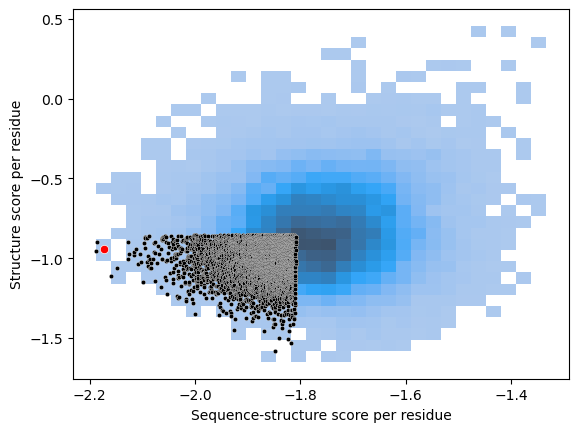

In [23]:
ax = sns.histplot(data=df,x='seqstruct_score_per_res',y='struct_score_per_res',bins=30)
ax = sns.scatterplot(data=score_filt_df,x='seqstruct_score_per_res',y='struct_score_per_res',s=10,c='black')
sns.scatterplot(data=native_df,x='seqstruct_score_per_res',y='struct_score_per_res',c='r')
ax.set_ylabel("Structure score per residue")
ax.set_xlabel("Sequence-structure score per residue")

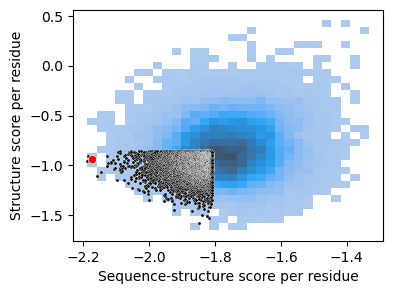

In [24]:
plt.figure(figsize=(4,3))
ax = sns.histplot(data=df,x='seqstruct_score_per_res',y='struct_score_per_res',bins=30)
ax = sns.scatterplot(data=score_filt_df,x='seqstruct_score_per_res',y='struct_score_per_res',s=5,c='black')
ax = sns.scatterplot(data=native_df,x='seqstruct_score_per_res',y='struct_score_per_res',c='r')
ax.set_ylabel("Structure score per residue")
ax.set_xlabel("Sequence-structure score per residue")
plt.savefig("230707_relBhelixextension1seed_5kselected.png",dpi=300,bbox_inches='tight')

In [25]:
df['N_peptide_res'].mean()

31.103018603018604

In [26]:
score_filt_df['N_peptide_res'].mean()

30.598

In [27]:
score_len_filt_df = score_filt_df.query('N_peptide_res <= 31')
score_len_filt_df.head()

,name,score_mode,N_target_res,N_peptide_res,seqstruct_score,struct_score,struct_score_per_res,seqstruct_score_per_res,nat_seq,consensus_seq,seq_id
23511,seed-4FXE-ARG81-relax-noHyd_E_B_E54_1196_247_2...,interface_only,81,28,-61.277779,-26.664860,-0.952316,-2.188492,FMVISPLYAGTSDSDEDAELVEIVKERL,MEYVVEDWTGEEEEEADAELREEVKELL,35.714286
9705,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,30,-65.545609,-27.033401,-0.901113,-2.184854,QTLLSDEDAELVEIVKERLSKNVGSKIHLP,DEEEEEEDAELREEVKEVIGNNEGSYFIIP,43.333333
5271,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,29,-62.272758,-30.844921,-1.063618,-2.147336,QTLLSDEDAELVEIVKERLENFQWQFHTP,DEEEEEEDAELREEVKEELKHYKLGYSVP,37.931034
19908,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,29,-61.698479,-29.206985,-1.007137,-2.127534,QTLLSDEDAELVEIVKERLENFQWQLHLN,DEEEEEEDAELREEVAEELKHYKIGLRIE,34.482759
25883,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,interface_only,81,29,-61.684483,-26.136230,-0.901249,-2.127051,QTLLSDEDAELVEIVKERLENFQWQWATG,DEEEEEEDAQLREEVAELGANYKVGWSLG,34.482759


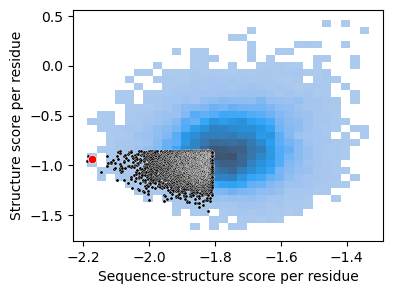

In [28]:
plt.figure(figsize=(4,3))
ax = sns.histplot(data=df,x='seqstruct_score_per_res',y='struct_score_per_res',bins=30)
ax = sns.scatterplot(data=score_len_filt_df,x='seqstruct_score_per_res',y='struct_score_per_res',s=5,c='black')
ax = sns.scatterplot(data=native_df,x='seqstruct_score_per_res',y='struct_score_per_res',c='r')
ax.set_ylabel("Structure score per residue")
ax.set_xlabel("Sequence-structure score per residue")
plt.savefig("230707_relBhelixextension1seed_31resorless_5kselected.png",dpi=300,bbox_inches='tight')

<Axes: xlabel='N_peptide_res', ylabel='Count'>

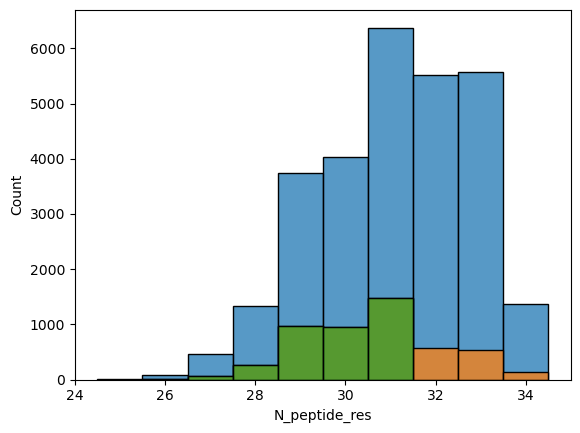

In [29]:
sns.histplot(data=df,x='N_peptide_res',discrete=True)
sns.histplot(data=score_filt_df,x='N_peptide_res',discrete=True)
sns.histplot(data=score_len_filt_df,x='N_peptide_res',discrete=True)

In [30]:
path = 'relBhelix_1seedextensions_31resorless_list.txt'
with open(path,'w') as file:
    for i,row in score_len_filt_df.iterrows():
        file.write(row['name']+'\n')

In [31]:
len(set(filt_df['name']))

5000

In [ ]:
multipdbpath = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4_repeatNativeExtensions/4_connectFragments_relBhelix-hotspotseeds_8resConnectors/fusedDB.pdb'
with multiPDBLoader(multipdbpath) as reader:
    reader.copyToNewMultiPDB(set(score_len_filt_df['name']),'relBhelix_1seedextensions_31resorless.pdb')

Scanning multi-PDB file...
Scanned the file in 1.280 s and found 28781 structures
